# Leader-Follower Relationships Optimize Coordination in Networked Jazz Performances

![image](https://user-images.githubusercontent.com/97224401/232460680-1542d4bb-46e7-4a25-bba0-dd206f61db64.png)

*The two musicians (pianist, left; drummer, right) whose performance we will be modelling.*

## Modelling one performance

This notebook walks through the process of loading in the data for a single performance from the corpus, extracting the relevant features, modelling the interaction within the performance using our phase correction model, running a series of experimental simulations using the model, and finally visualising the results using a variety of in-built plots.

For this example notebook, the performance we've selected to analyse is by the duo 3 (of five), from the first (of two) experimental sessions, with 90 milliseconds of latency and 0.0x jitter scaling.

## 1. Load dependencies, set constants

**Process:**
- Install dependencies that Google CoLab does not install by default;
- Import dependencies that we need when working with our data;
- Set PATH correctly
- Set constant variables (number of simulations, example data)

The following lines of code install the packages that Google CoLab does not contain by default

In [1]:
# TODO: we should install all the modules that the default colab notebook needs here

Although most of the dependencies are imported within the analysis and visualisation scripts we'll be loading here, we still need to import a few additional dependencies here to have access to the objects we're going to create.

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

When running this script locally (i.e. from inside the `.\notebooks` directory), we need to add the module root temporarily to our PATH variable in order to access our analysis scripts (located inside `.\src`)

In [3]:
sys.path.append(os.path.abspath(".."))

The following lines of code set dependencies which can be adjusted by the user.

In [4]:
INPUT_DIR = r"..//references//example_for_notebook"    # Default ..//references//example_for_notebook
MIDI_MAPPING_FPATH = r'..//references'    # Default ..//references
NUM_SIMULATIONS = 250    # Default 250: increasing this value will demand greater system resources!

## 2. Load and clean the raw data

In [5]:
from src.clean.gen_pretty_midi import gen_raw_midi_output, gen_pm_output
from src.clean.combine import combine_output

The following few lines of code generate our *raw* MIDI data (equivalent to every note played by a performer) and the *BPM* MIDI data (equivalent just to the crotchet beats they played). Both data streams are stored as .MID files created using our AV-Manip software in Reaper.

In [6]:
output = {}
output['midi_raw'] = gen_raw_midi_output(input_dir=INPUT_DIR, midi_mapping_fpath=MIDI_MAPPING_FPATH)
output['midi_bpm'] = gen_pm_output(input_dir=INPUT_DIR, midi_mapping_fpath=MIDI_MAPPING_FPATH)

Now, we combine all of our data streams together.

In [7]:
combined = combine_output(input_dir=MIDI_MAPPING_FPATH, output_dir=INPUT_DIR, **output)

Note that, for sake of simplicity, we don't extract the questionnaire responses or biometric data for each musician; however, there are functions present in `.\src\clean\` that will do this (and are called when the full model set is created). As a result, we need to add some placeholder variables into our cleaned data, so we don't end up with errors when creating our model.

In [8]:
for p in combined:
    for t in p:
        # We set the questionnaire variables to NoneType
        # This will prevent issues if these variables don't exist
        for val in ['interaction', 'coordination', 'success', 'thoughts']:
            t[val] = None

## 3. Create the model
**Process:**
- Import the `PhaseCorrectionModel` class
- Create the model using our raw keys and drums data
- Print the nearest-neighbour matched data for the pianist
- Print the model summary for the drummer
- Create a summary dataframe combining results from both musicians

In [9]:
from src.analyse.phase_correction_models import PhaseCorrectionModel

C:\Python Projects\jazz-jitter-analysis\venv\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Now, we separate our raw data variable into a separate dictionary for both the pianist and drummer. We pass these into our `PhaseCorrectionModel` constructor to create the model. The other arguments in our call to `PhaseCorrectionModel` here are just set to their defaults: however, they are defined so you can try altering them and see what happens.

In [10]:
keys_raw, drms_raw = combined[0]
md = PhaseCorrectionModel(
    # Raw data (don't change this!)
    c1_keys=keys_raw,
    c2_drms=drms_raw,
    # Patsy model to use (don't change unless you know what you're doing)
    model='my_next_ioi_diff~my_prev_ioi_diff+asynchrony',    
    # Upper and lower bound to filter outlying IOIs
    iqr_filter=(0.1, 0.9),   
    # Size of the window in seconds to use when generating rolled values
    rolling_window_size='2s',
    # Minimum number of periods to use when generating rolled data
    rolling_min_periods=2,
    # Maximum number of seconds to lag the latency array by
    maximum_lag=8,
    # Maximum order (M) to create higher-level phase correction models up to
    higher_level_order=4,
)

Once we've created our model, we can access a few attributes which might be helpful. First, we'll print the first 5 matched onsets (from the keyboard player's perspective) as a Pandas `DataFrame`. For clarity, 'my' refers to the keyboard player, and 'their' to the drummer:

In [26]:
md.keys_nn.head(5)

,my_onset,their_onset,asynchrony,latency,their_onset_delayed,my_onset_delayed,asynchrony_raw,asynchrony_third_person,my_prev_ioi,their_prev_ioi,my_next_ioi,my_next_ioi_diff,my_prev_ioi_diff,my_prev_ioi_diff_l1,asynchrony_l1,my_prev_ioi_diff_l2,asynchrony_l2,my_prev_ioi_diff_l3,asynchrony_l3,my_prev_ioi_diff_l4,asynchrony_l4
0,8.022917,8.026042,0.093125,0.09,8.116042,8.112917,0.003125,0.003125,NaN,NaN,0.577083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8.600000,8.497917,-0.012083,0.09,8.587917,8.690000,-0.102083,-0.102083,0.577083,0.471875,0.510938,-0.066146,NaN,NaN,0.093125,NaN,NaN,NaN,NaN,NaN,NaN
2,9.110938,9.080208,0.059271,0.09,9.170208,9.200938,-0.030729,-0.030729,0.510938,0.582292,0.550000,0.039062,-0.066146,NaN,-0.012083,NaN,0.093125,NaN,NaN,NaN,NaN
3,9.660937,9.695833,0.124896,0.09,9.785833,9.750937,0.034896,0.034896,0.550000,0.615625,0.686458,0.136458,0.039062,-0.066146,0.059271,NaN,-0.012083,NaN,0.093125,NaN,NaN
4,10.347396,10.253125,-0.004271,0.09,10.343125,10.437396,-0.094271,-0.094271,0.686458,0.557292,0.596875,-0.089583,0.136458,0.039062,0.124896,-0.066146,0.059271,NaN,-0.012083,NaN,0.093125


Next, we'll print a summary of the model itself (as a StatsModels `OLSResults` instance) for the drummer:

In [12]:
md.drms_md.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       my_next_ioi_diff   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     48.57
Date:                Mon, 17 Apr 2023   Prob (F-statistic):           2.84e-16
Time:                        16:22:43   Log-Likelihood:                 194.92
No. Observations:                 126   AIC:                            -383.8
Df Residuals:                     123   BIC:                            -375.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0803      0.012     -6.575      0.000      -0.105      -0.056
my_prev_ioi_diff    -0.2867      0.066     -4.370      0.000      -0.417      -0.157
asynchrony           0.5994      0.082      7.339      0.000       0.438       0.761
==============================================================================
Omnibus:                        8.304   Durbin-Watson:                   2.164
Prob(Omnibus):                  0.016   Jarque-Bera (JB):               10.564
Skew:                           0.376   Prob(JB):                      0.00508
Kurtosis:                       4.203   Cond. No.                         18.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

If you look at the code for `PhaseCorrectionModel`, you'll notice that there are lots of private methods (e.g. `_extract_tempo_slope()`) that carry out particular analyses tasks. Rather than call these methods individually, we can access the pre-computed results using either the `md.keys_dic` or `md.drms_dic` attribute.

In [13]:
md.keys_dic

{'trial': 3,
 'block': 1,
 'latency': 90,
 'jitter': 0.0,
 'instrument': 'Keys',
 'raw_beats': [array([[8.022916666666667, 'A#1', 54],
         [8.6, 'A#2', 94],
         [9.1109375, 'D2', 73],
         [9.6609375, 'E2', 51],
         [10.347395833333334, 'D#2', 58],
         [10.944270833333333, 'D#3', 94],
         [11.566666666666666, 'G3', 63],
         [12.222916666666666, 'A#2', 40],
         [12.838020833333333, 'F2', 58],
         [13.438541666666666, 'F3', 74],
         [14.0671875, 'D3', 73],
         [14.666666666666666, 'F2', 80],
         [15.392708333333333, 'F3', 77],
         [16.0703125, 'D3', 85],
         [16.708333333333332, 'E2', 89],
         [17.357291666666665, 'B2', 85],
         [18.052083333333332, 'D#2', 84],
         [18.715104166666666, 'G3', 67],
         [19.440625, 'D#2', 56],
         [20.092708333333334, 'G3', 61],
         [20.711458333333333, 'D#2', 41],
         [21.3359375, 'G3', 61],
         [21.9953125, 'E2', 73],
         [22.684375, 'E3', 77]

Finally, we compile a `DataFrame` using both the `md.keys_dic` and `md.drms_dic` attributes together. When working with the full corpus, we can use this to create a nice table, where a single row corresponds to the performance of one musician in one condition. But, for now, we'll just have two rows, one for each performer in our example extract.

In [14]:
df = pd.DataFrame([md.keys_dic, md.drms_dic])
df

,trial,block,latency,jitter,instrument,raw_beats,all_beats,zoom_arr,total_beats,interpolated_beats,repeat_notes,asynchrony_na,tempo_slope,ioi_std,pw_asym,success,tempo_intercept,my_prev_ioi_diff_mean,my_next_ioi_diff_mean,ioi_std_vs_jitter_partial_correlation,asynchrony_mean,pw_asym_indiv,pw_asym_raw,pw_asym_std,pw_asym_raw_std,interaction,coordination,intercept,correction_self,correction_partner,contamination,resid_std,resid_len,rsquared,rsquared_adj,aic,bic,log-likelihood,higher_order_rsquared,higher_order_rsquared_adj,higher_order_aic,higher_order_bic,higher_order_log-likelihood,coupling_1st,coupling_2nd
0,3,1,90,0.0,Keys,"[[[8.022916666666667, A#1, 54], [8.6, A#2, 94]...","[[[7.843229166666666, A#2, 75], [8.02291666666...","[90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90....",130,2,0,1,-0.208071,36.488083,75.725048,None,95.202185,0.003512,0.003512,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.043492,73.911546,75.889999,107.09139,107.324666,None,None,-0.025495,-0.425797,0.697533,0.0,0.043551,127,0.581764,0.575018,-429.579174,-421.046612,217.789587,"[0.6628486962583497, 0.7067634107300216, 0.712...","[0.6517031986139977, 0.6918530756823955, 0.692...","[-448.5787120346698, -461.30728464918434, -456...","[-434.3973024999124, -441.50908848806824, -431...","[229.2893560173349, 237.65364232459217, 237.45...",0.499212,0.839543
1,3,1,90,0.0,Drums,"[[[8.026041666666666, Ride Bow Tip, 48], [8.49...","[[[7.5, Hi-Hat Pedal, 31], [7.785416666666666,...","[90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90....",131,0,0,2,-0.208071,38.920003,75.725048,None,95.202185,0.002552,0.002552,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.136508,149.015600,75.889999,107.09139,107.324666,None,None,-0.080333,-0.286679,0.599372,0.0,0.051515,126,0.441246,0.432161,-383.831587,-375.322742,194.915794,"[0.47515595986452785, 0.515349640161923, 0.510...","[0.45766115852667877, 0.4902815181013328, 0.47...","[-383.7894139266492, -382.05896973011613, -370...","[-369.6478452401377, -362.3736792425092, -345....","[196.8947069633246, 198.02948486505807, 194.10...",0.576284,0.635729


## 4. Generate all the simulations
**Process:**
- Create the required simulation paradigms (e.g. `anarchy`, `democracy` etc.)
- Create the simulation objects for each paradigm

First, we need to import our Simulation class:

In [15]:
from src.analyse.simulations import Simulation

We can now proceed to create each of our simulation paradigms. These are:
- `original`: coupling coefficients defined in the model
- `democracy`: both performers coupled to each other at equal rates
- `anarchy`: no adaptation or correction between performers
- `leadership`: pianist coupled to drummer, drummer not coupled to pianist

Our `original` simulation paradigm just uses the coefficients defined in the model, for both performers.

In [16]:
original = df.copy()

Our `democracy` paradigm sets the coupling of both performers precisely equal to each other, to the mean coefficient. We set the intercept to `0` to ensure the stability of the simulation.

In [17]:
democracy = df.copy()
democracy['correction_partner'] = democracy['correction_partner'].mean()
democracy['intercept'] = 0

Our `anarchy` model sets the coupling of both performers to `0`, simulating no adaptation or correction between them. Again, we set the intercept to `0` to ensure the stability of the simulation.

In [18]:
anarchy = df.copy()
anarchy['correction_partner'] = 0
anarchy['intercept'] = 0

Finally, our `leadership` model sets the coupling of the drummer to the pianist to `0` but does not change the coupling of the pianist to the drummer, simulating a leader-follower relationship (with the drummer as the leader). We again set the intercept to `0` to ensure the stability of the simulation.

In [19]:
leadership = df.copy()
leadership['correction_partner'] = np.where(
    leadership['instrument'] == 'Drums', 0,
    leadership[leadership['instrument'] == 'Keys']['correction_partner']
)
leadership['intercept'] = 0

OK, now we can create all of our simulations. The following code iterates over all of the paradigms we defined above, creates the `Simulation` object for each paradigm, creates the desired number of individual simulated performances (defined in the `NUM_SIMULATIONS` constant), then stores the results in our `sims_list` iterable that we'll access when creating our graphs later.

In [20]:
sims_list = []
for md_, param in zip(
    [original, anarchy, democracy, leadership], 
    ['original', 'anarchy', 'democracy', 'leadership'],
):
    sim_ = Simulation(
        # The phase correction model results
        pcm=md_,
        # The number of simulations we'll run, defaults to 250
        num_simulations=NUM_SIMULATIONS,
        # This argument is just used to store the parameter used as a string inside the Simulation instance
        parameter=param, 
        # Tells the simulation to use the original noise term of the model
        use_original_noise=False,
        noise=0.005
    )
    sim_.create_all_simulations()
    sims_list.append(sim_)

## 5. Create some graphs

**Process:**
- Create a plot showing modelled coupling coefficients, relative phase, and tempo
- Create a plot comparing between simulated tempo and asynchrony across paradigms

First, we'll create a nice plot of the individual coupling coefficients obtained for each performer, the relative phase of each performer compared to their partner (whether they play 'in-front' or 'behind'), and the tempo trajectory of their performance.

In [22]:
from src.visualise.phase_correction_graphs import SingleConditionPlot
from src.analyse.analysis_utils import generate_df

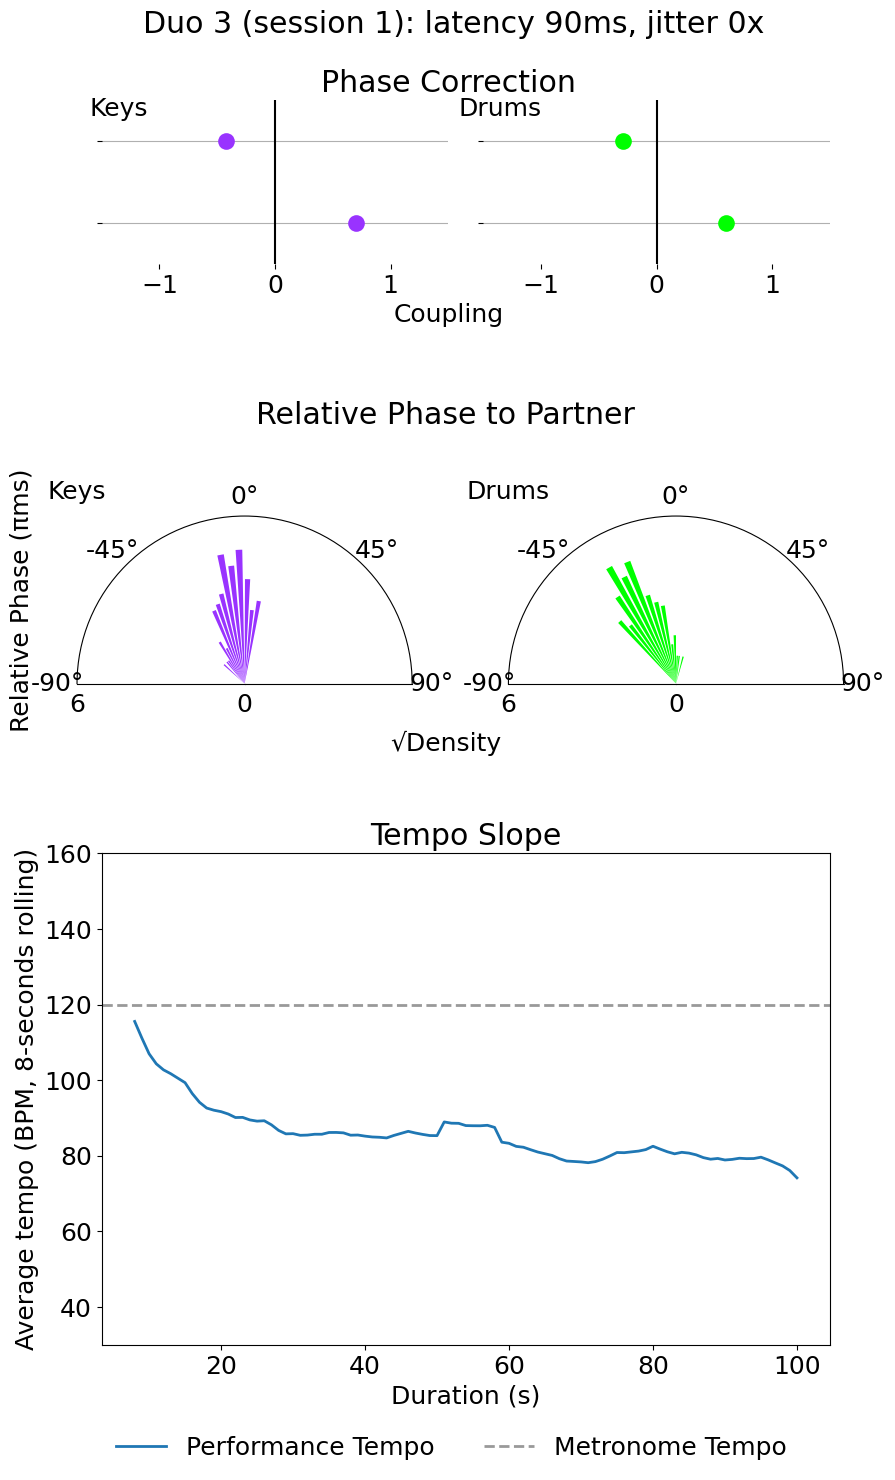

In [23]:
g = SingleConditionPlot(
    # Keys data
    keys_df=md.keys_nn,
    keys_md=md.keys_md,
    keys_o=generate_df(md.keys_dic['raw_beats'][0]),
    # Drums data
    drms_df=md.drms_nn,
    drms_md=md.drms_md,
    drms_o=generate_df(md.drms_dic['raw_beats'][0]),
    # Metadata used to create the plot title, etc.
    metadata=(
        3, 1, 90, 0
    )
)
g.create_plot()
plt.show()

Finally, we'll generate a line plot that compares the simulated tempo and asynchrony values obtained across all of our paradigms.

In [24]:
from src.visualise.simulations_graphs import LinePlotAllParameters

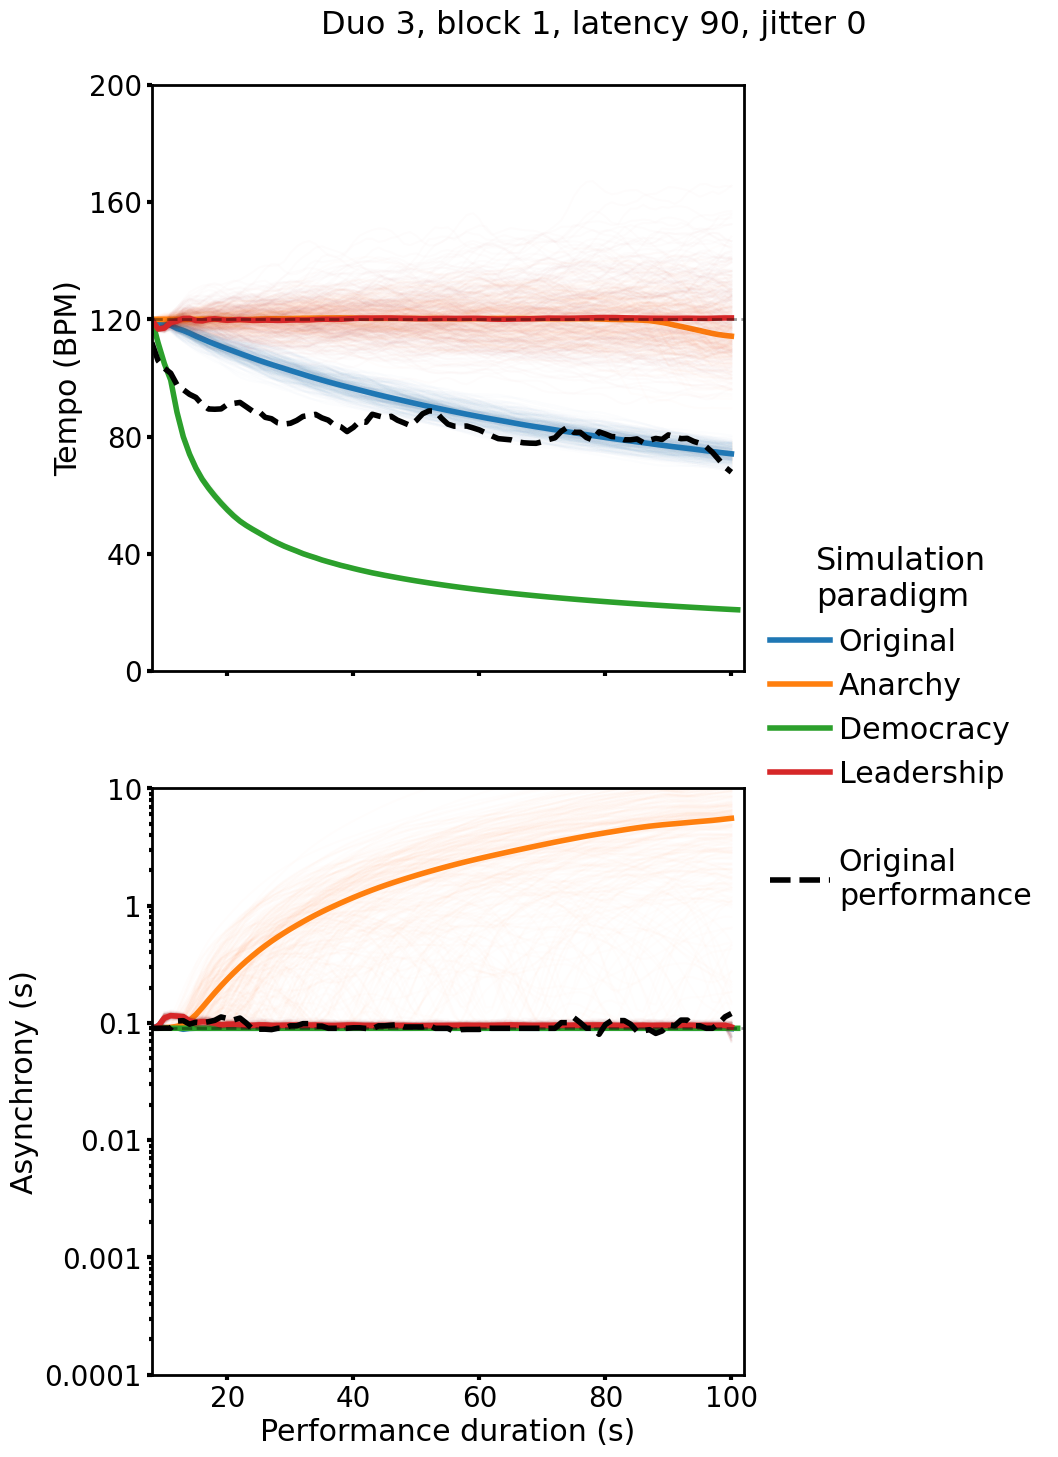

In [25]:
g = LinePlotAllParameters(
    simulations=sims_list,
    keys_orig=md.keys_nn,
    drms_orig=md.drms_nn,
    # Metadata used to create the plot title, etc.
    params={
        'trial': 3,
        'block': 1,
        'latency': 90,
        'jitter': 0
    }
)
g.create_plot()
plt.show()